# Plotting results

In [1]:
%reload_ext autoreload
%reload_ext blackcellmagic
%autoreload 2
%config InlineBackend.figure_format='retina'
%config InlineBackend.figure_format='svg'

In [2]:
import os
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import glob
import re
import matplotlib as mpl

figwidth, figheight = mpl.rcParams["figure.figsize"]

In [3]:
# base = os.path.abspath('../results/2021-05-03/')
dataset = 'ml100k'
dataset = 'mind'
dataset = 'ml1m'
base = os.path.abspath(f'../results/{dataset}/')
paths = [p for p in glob.glob(base + '/*.csv')]
paths

['/home/khalil/projects/bpr/results/ml1m/wandb_export_2021-05-04T11_20_35.915+01_00.csv',
 '/home/khalil/projects/bpr/results/ml1m/wandb_export_2021-05-04T11_20_28.536+01_00.csv']

In [4]:
metrics = {}

for path in paths:
    df = pd.read_csv(path)
    for column in df.columns:
        word = column.split()[-1]
        if word.lower()[-4:] not in ("_max", "_min", "step"):
            metrics[word] = path

In [5]:
metrics

{'ndcg': '/home/khalil/projects/bpr/results/ml1m/wandb_export_2021-05-04T11_20_35.915+01_00.csv',
 'precision': '/home/khalil/projects/bpr/results/ml1m/wandb_export_2021-05-04T11_20_28.536+01_00.csv'}

In [6]:
def load_df_from_metric(metric, metrics):
    df = pd.read_csv(metrics[metric]).drop(columns=['Step'])
    df.columns = [c.lower() for c in df.columns]

    cols_summary = tuple(c for c in df.columns if c.endswith('_min') or c.endswith('_max'))
    cols_raw = tuple(c for c in df.columns if not (c.endswith('_min') or c.endswith('_max')))

    taboo = '|'.join(('ml100k', 'bpr', 'precision', 'ndcg', 'dl05', ' ', '-', 'mind', 'ml1m'))
    aliases = {c: re.sub(taboo, '', c) for c in df.columns}

    df = df.rename(columns=aliases)
    return df

In [7]:
df_prec = load_df_from_metric('precision', metrics)
df_ndcg = load_df_from_metric('ndcg', metrics)

In [8]:
def plot_trend(ax, df, label_aliases, ylabel, ylim, xlim, legend_ncol=1, legend=True, exclude_cols=None):
    label_aliases = label_aliases or {}
    exclude_cols = exclude_cols or {}
    for col in sorted(df.columns):
        is_sumary_col = col.endswith("__min") or col.endswith("__max")
        if is_sumary_col or col in exclude_cols:
            continue
        values = df[col].values
        values = values[~np.isnan(values)]
        values_max = np.max(values)
        values_argmax = np.argmax(values)
        print(f'{col=} | {values_max=:.4f} | {values_argmax=:,}')
        
        sns.lineplot(
            y=values[:values_argmax],
            x=df.index[:values_argmax],
            legend=False,
            palette="Set2",
            label=label_aliases.get(col, col),
            linewidth=2.5,
            ax=ax
        )

    ax.set(ylim=ylim, ylabel=ylabel, xlim=xlim)
    if legend:
        ax.legend(
            ncol=legend_ncol,
            fontsize="small",
            loc="lower right",
        )
    ax.grid(ls=":", color="gainsboro")
    return ax

In [9]:
xlims = {
    'mind': {'precision': (0, 100), 'ndcg': (0, 100)},
    'ml100k': {'precision': (0, 100), 'ndcg': (0, 100)},
    'ml1m': {'precision': (0, 100), 'ndcg': (0, 100)},
}
ylims = {
    'mind': {'precision': (0, 0.1), 'ndcg': (0, 0.2)},
    'ml100k': {'precision': (0, 0.4), 'ndcg': (0, 0.8)},
    'ml1m': {'precision': (0, 0.4), 'ndcg': (0, 0.8)},
}

In [10]:
label_aliases = {
    "random": "Random Batch",
    "rb": "Recency Bias",
    "rbsim": "Recency Sim",
    "obs": "Online Batch",
    "dual3": "Simple Batch",
    "sim": "Similarity Batch",
}
exclude_cols = frozenset(["rb", "obs", "dual3", "sim"])
# exclude_cols = frozenset(["dual3"])
# exclude_cols = {}

params = [
    dict(
        exclude_cols=frozenset(["rb", "obs", "dual3", "sim"]),
        file_template="convergence-{}.pdf",
    ),
    dict(exclude_cols={'obs'}, file_template="convergence-all-{}.pdf"),
]

In [11]:
def plot_subplots(exclude_cols, df_prec, df_ndcg, file_template, dataset, write_name=True):
    print(dataset, file_template, dataset)
    with sns.plotting_context("paper"):
        with mpl.style.context("tableau-colorblind10"):
            fig, (ax0, ax1) = plt.subplots(figsize=(figwidth * 1.5, 2.5), ncols=2)
            plot_trend(
                ax=ax0,
                df=df_prec,
                label_aliases=label_aliases,
                ylabel="Precision@10",
                ylim=ylims[dataset]["precision"],
                xlim=xlims[dataset]["precision"],
                legend=False,
                exclude_cols=exclude_cols
            )
            plot_trend(
                ax=ax1,
                df=df_ndcg,
                label_aliases=label_aliases,
                ylabel="NDCG@10",
                ylim=ylims[dataset]["ndcg"],
                xlim=xlims[dataset]["ndcg"],
                legend=False,
                exclude_cols=exclude_cols
            )
            plt.gca().legend(
                ncol=2,
                fontsize="small",
                loc="lower right",
            )
            bbox = dict(boxstyle ="round", fc ="lightyellow", ec='silver',  alpha=0.7)
            # ax0.annotate(dataset.upper(), bbox=bbox, xy=(20, 0.015), xycoords='subfigure fraction')
            ax0.annotate(dataset.upper(), bbox=bbox, xy=(0.1, 0.85), xycoords='subfigure fraction')
            sns.despine()
    plt.tight_layout()
    # plt.savefig(f"convergence-{dataset}.pdf")
    plt.savefig(file_template.format(dataset))
    # plt.savefig(f"convergence-all-{dataset}.pdf")

In [12]:
# plot_subplots(params[0]['exclude_cols'], params[0]['file_template'], dataset)
# plot_subplots(params[1]['exclude_cols'], params[1]['file_template'], dataset)

<hr>

In [13]:
def run_all(dataset):
    base = os.path.abspath(f'../results/{dataset}/')
    paths = [p for p in glob.glob(base + '/*.csv')]

    metrics = {}

    for path in paths:
        df = pd.read_csv(path)
        for column in df.columns:
            word = column.split()[-1]
            if word.lower()[-4:] not in ("_max", "_min", "step"):
                metrics[word] = path

    df_prec = load_df_from_metric('precision', metrics)
    df_ndcg = load_df_from_metric('ndcg', metrics)


    for param in params:
        plot_subplots(exclude_cols=param['exclude_cols'], file_template=param['file_template'], dataset=dataset, df_prec=df_prec, df_ndcg=df_ndcg)

ml100k convergence-{}.pdf ml100k
col='random' | values_max=0.3426 | values_argmax=96
col='rbsim' | values_max=0.3462 | values_argmax=40
col='random' | values_max=0.7653 | values_argmax=98
col='rbsim' | values_max=0.7647 | values_argmax=40
ml100k convergence-all-{}.pdf ml100k
col='dual3' | values_max=0.3462 | values_argmax=40
col='random' | values_max=0.3426 | values_argmax=96
col='rb' | values_max=0.3482 | values_argmax=99
col='rbsim' | values_max=0.3462 | values_argmax=40
col='dual3' | values_max=0.7539 | values_argmax=40
col='random' | values_max=0.7653 | values_argmax=98
col='rb' | values_max=0.7719 | values_argmax=80
col='rbsim' | values_max=0.7647 | values_argmax=40


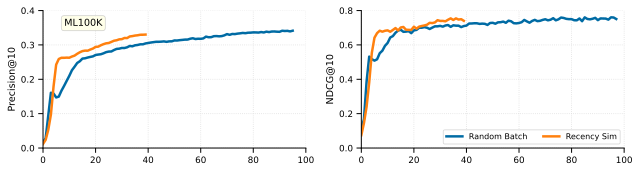

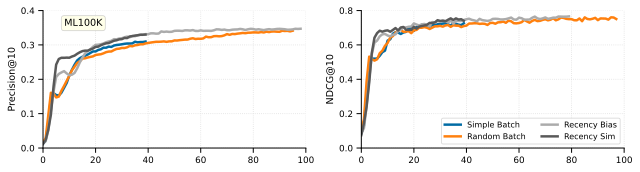

ml1m convergence-{}.pdf ml1m
col='random' | values_max=0.3110 | values_argmax=68
col='rbsim' | values_max=0.3071 | values_argmax=28
col='random' | values_max=0.7161 | values_argmax=68
col='rbsim' | values_max=0.7109 | values_argmax=27
ml1m convergence-all-{}.pdf ml1m
col='dual3' | values_max=0.3094 | values_argmax=25
col='random' | values_max=0.3110 | values_argmax=68
col='rb' | values_max=0.3109 | values_argmax=58
col='rbsim' | values_max=0.3071 | values_argmax=28
col='sim' | values_max=0.3113 | values_argmax=53
col='dual3' | values_max=0.7133 | values_argmax=21
col='random' | values_max=0.7161 | values_argmax=68
col='rb' | values_max=0.7129 | values_argmax=55
col='rbsim' | values_max=0.7109 | values_argmax=27
col='sim' | values_max=0.7068 | values_argmax=53


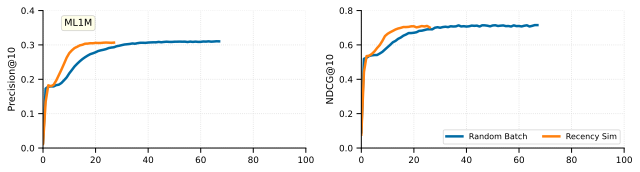

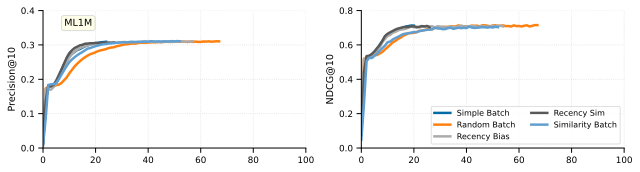

mind convergence-{}.pdf mind
col='random' | values_max=0.0235 | values_argmax=109
col='rbsim' | values_max=0.0225 | values_argmax=50
col='random' | values_max=0.1340 | values_argmax=86
col='rbsim' | values_max=0.1270 | values_argmax=50
mind convergence-all-{}.pdf mind
col='dual3' | values_max=0.0223 | values_argmax=28
col='random' | values_max=0.0235 | values_argmax=109
col='rb' | values_max=0.0229 | values_argmax=75
col='rbsim' | values_max=0.0225 | values_argmax=50
col='sim' | values_max=0.0226 | values_argmax=70
col='dual3' | values_max=0.1264 | values_argmax=28
col='random' | values_max=0.1340 | values_argmax=86
col='rb' | values_max=0.1327 | values_argmax=80
col='rbsim' | values_max=0.1270 | values_argmax=50
col='sim' | values_max=0.1298 | values_argmax=72


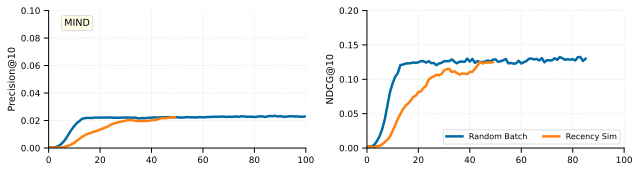

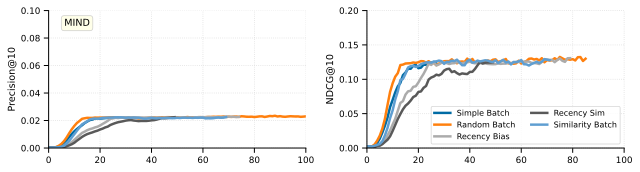

In [14]:
for dataset in ('ml100k', 'ml1m', 'mind'):
#     if dataset != 'mind':
#         continue
    run_all(dataset)
    plt.show()
#     plt.clf()

In [46]:
import sys
sys.path.append('../bpr')
from kutils import load_amazon

In [52]:
!pwd

/home/khalil/projects/bpr/notebooks


In [57]:
df = load_amazon('/home/khalil/projects/bpr/data/amazon/amazon-new/')
# df = load_amazon('../data/amazon/amazon-new/')

In [41]:
df.shape

(62376, 3)

In [39]:
df_train.head()

,user_id,item_id,rating
0,0,33,1
1,0,36,1
2,0,4,1
3,0,13,1
4,0,30,1


In [18]:
!ls ../data/lastfm

test.csv  train.csv  val.csv
